In [1]:
import os
import re
import sys
basepath = '/' + os.path.join('Users', 'zach', 'Git', 'Masterarbeit', 'Project')
sys.path.append(basepath)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tikzplotlib as tkz

# Enable full width output for numpy (https://stackoverflow.com/questions/43514106/python-terminal-output-width)
np.set_printoptions(suppress=True, linewidth=1000, threshold=1000)

from src.ml.training import load_model
from sklearn.pipeline import Pipeline
from src.d.transformators import TransformData, FindGradient, FindAngle, Rotate, CDS, HF, TwoLayers, Shift
from data.fortran_test.utils import get_predictions, plot_vofs, create_plot
from src.ml.building import custom_loss

In [19]:
gridsize = 128

folder = {}
data = {}
kappa = {}
x = {}
y = {}
stencils = {}
label = {}
# dsrcs = ['cds ohne', 'cds mit', 'ml ohne', 'ml mit', 'cvofls', 'ml sharp', 'hf']
dsrcs = [ 'cvofls',  'hf']
#dsrcs = ['cds mit', 'ml ohne', 'ml mit']

for dsrc in dsrcs:
    # Daten muessen mit tecplot2data.py aus staticbubble.dat (aus TecPlot) erzeugt werden
    if dsrc == 'cds mit':
        folder[dsrc] = f'2007181652 staticBubble {gridsize} cds mit w+g'
        label[dsrc] = 'CV'
    if dsrc == 'cds ohne':
        folder[dsrc] = f'2007181652 staticBubble {gridsize} cds ohne w+g'
        label[dsrc] = 'CV'
    elif dsrc == 'ml mit':
        folder[dsrc] = f'2007181652 staticBubble {gridsize} ml mit w+g'
        label[dsrc] = 'ANN intp.'
    elif dsrc == 'ml ohne':
        folder[dsrc] = f'2007181652 staticBubble {gridsize} ml ohne w+g'
        label[dsrc] = 'ANN'
    elif dsrc == 'cvofls':
        folder[dsrc] = f'2007181652 staticBubble {gridsize} cvofls'
        label[dsrc] = 'CVOFLS'
    elif dsrc == 'ml sharp':
        # folder[dsrc] = f'2008041519 staticBubble 128 ml sharp'
        folder[dsrc] = f'2008161150 staticBubble {gridsize} ml sharp 9x9'
        label[dsrc] = 'ANN scharf'
    elif dsrc == 'hf':
        folder[dsrc] = f'2008151036 staticBubble {gridsize} HF'
        label[dsrc] = 'HF'
        
    data[dsrc] = pd.read_feather(os.path.join(folder[dsrc], 'res', 'staticbubble.feather'))
    kappa[dsrc] = np.array(data[dsrc].iloc[:, 0])
    stencils[dsrc] = np.array(data[dsrc].iloc[:, 1:-2])
    x[dsrc] = np.array(data[dsrc].iloc[:, -2])
    y[dsrc] = np.array(data[dsrc].iloc[:, -1])
    np.random.seed(3)
    indices = np.random.permutation(kappa[dsrc].shape[0])
    kappa[dsrc] = kappa[dsrc][indices]
    stencils[dsrc] = stencils[dsrc][indices, :]

ML mit = mit w+g, ML ohne = ohne w+g
Mittelwert/Standardabweichung cvofls:	0.4990,	0.2136
Mittelwert/Standardabweichung hf:	0.4644,	0.3209


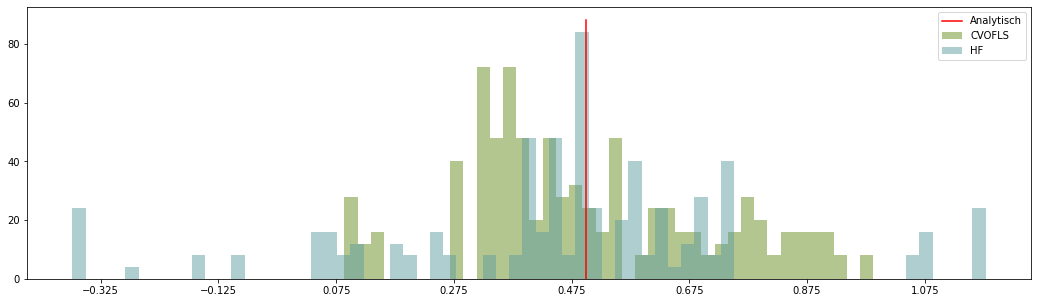

In [20]:
roud = 3
print('ML mit = mit w+g, ML ohne = ohne w+g')
dsrcs = ['cvofls', 'hf', 'ml mit', 'ml sharp']
dsrcs = [ 'cvofls',  'hf']
# dsrcs = ['cvofls', 'cds mit']
fig, ax = plt.subplots(figsize = (18,5))
for dsrc in dsrcs:
    print(f'Mittelwert/Standardabweichung {dsrc}:\t{np.mean(kappa[dsrc]):.4f},\t{np.std(kappa[dsrc]):.4f}')
    
    if dsrc == 'hf':
        color = 'cadetblue'
    elif dsrc == 'cds ohne':
        color = 'k'
    elif dsrc == 'ml mit':
        color = 'goldenrod'
    elif dsrc == 'ml ohne':
        color = 'g'
    elif dsrc == 'ml sharp':
        color = 'orchid'
    elif dsrc == 'cvofls':
        color = 'olivedrab'
        
    rng = kappa[dsrc].max()-kappa[dsrc].min()
    
    # Vertikal
    ax.hist(kappa[dsrc], bins=int(rng*45*128/gridsize), label=label[dsrc], alpha=0.5, stacked=True, color=color)
    # Horizontal
    #ax.hist(kappa[dsrc], bins=int(rng*25), label=dsrc, alpha=0.5, density=True, orientation='horizontal')
xlim = ax.get_xlim()[1]
ylim = ax.get_ylim()[1]
ax.xaxis.set_major_locator(ticker.IndexLocator(base=0.2, offset=-0.152))
#plt.plot([0, xlim], [0.5, 0.5], label='analytisch')
plt.plot([0.5, 0.5], [0, ylim], label='Analytisch', color='r')
plt.legend()
#x1,x2,y1,y2 = plt.axis()
#plt.axis((0.15,0.85,y1,y2))
tkz.save(f'Result_Static_Bubble1_{gridsize}.tex', axis_height='6cm', axis_width='15cm')

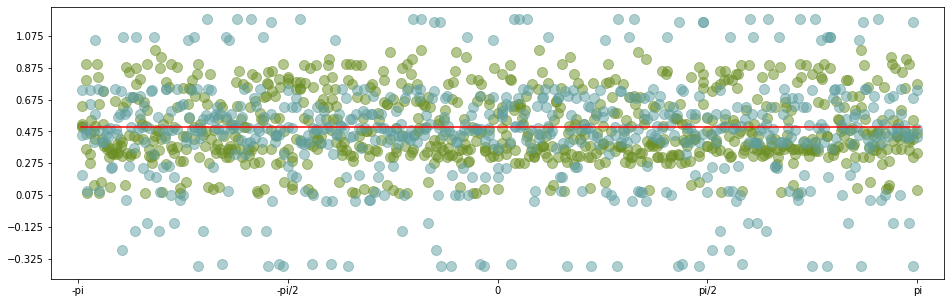

In [21]:
theta = {}
fig, ax = plt.subplots(figsize = (16,5))
alpha = 0.5
marker = 'o'
size = 100

dsrcs = ['cvofls', 'hf', 'ml mit', 'ml sharp']
dsrcs = [ 'cvofls',  'hf']
# dsrcs = ['cvofls', 'cds mit']
#dsrcs = ['cds mit']

for dsrc in dsrcs:
    if kappa[dsrc].shape[0] > 800:
        # Take 800 random values (otherwise Latex will throw tex capacity exceeded error)
        ind = np.random.permutation(kappa[dsrc].shape[0])
        ind = ind[:800]
        theta[dsrc] = np.arctan2(y[dsrc][ind]-4, x[dsrc][ind]-4)
        indices = np.argsort(theta[dsrc])
    
        printdata = np.stack((theta[dsrc][indices], kappa[dsrc][ind][indices]))
    else:
        theta[dsrc] = np.arctan2(y[dsrc]-4, x[dsrc]-4)
        indices = np.argsort(theta[dsrc])

        printdata = np.stack((theta[dsrc][indices], kappa[dsrc][indices]))
    
    if dsrc == 'hf':
        color = 'cadetblue'
    elif dsrc == 'cds ohne':
        color = 'k'
    elif dsrc == 'ml mit':
        color = 'goldenrod'
    elif dsrc == 'ml ohne':
        color = 'g'
    elif dsrc == 'ml sharp':
        color = 'orchid'
    elif dsrc == 'cvofls':
        color = 'olivedrab'
    
    ax.scatter(printdata[0, :], printdata[1, :], label=label[dsrc], alpha=alpha, marker=marker, s=size, edgecolors='none', color=color, ec=color)
    #ax.plot(printdata[0, :], printdata[1, :], label=dsrc, alpha=alpha, marker=marker)
ax.plot([-np.pi+0.02, np.pi+0.02], [0.5, 0.5], color = 'r', label='Analytisch')
ax.set_xlim([-np.pi-0.2, np.pi+0.2])
plt.xticks(ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels=['-pi', '-pi/2', 0, 'pi/2', 'pi'])
ax.yaxis.set_major_locator(ticker.IndexLocator(base=0.2, offset=-0.152))
# ax.legend()
tkz.save(f'Result_Static_Bubble2_{gridsize}.tex', axis_height='5cm', axis_width='16cm')
    